# HSC Amp-to-Amp Offsets

## Useful links
* [LSKs GitHub Repo](https://github.com/leeskelvin/amp2amp)
* [Jira Ticket (DM-20303)](https://jira.lsstcorp.org/browse/DM-20303)
* [Dropbox paper: Background Exploration Aug 2018](https://paper.dropbox.com/doc/Background-Exploration-Aug-2018--ApTKzYDGr98X1Dl_UXBp5iGGAg-62Gc0Msel3yCa6VEtRVy7)
* [Eli's original analysis code](https://raw.githubusercontent.com/leeskelvin/amp2amp/master/ref/compute_and_plot_amp_offsets_pdr1_perpix4.py)
* [Eli's presentation: HSC Background Offsets: What's Up With That?](https://github.com/leeskelvin/amp2amp/blob/master/ref/hsc_background_offsets.pdf)
* [Boone et al. 2018](https://github.com/leeskelvin/amp2amp/blob/master/ref/Boone2018::2018PASP..130f4504B.pdf)

In [1]:
# setup options
visit = 1252
outdir = 'visit%05d' % (visit)
rerundir = '/project/lskelvin/hsc-rerun/isrvanilla1252'
rerunfileglob = '%s/v%07d*/*.fits' % (rerundir, visit)

<h2>HSC CCD Arrangement</h2>
<h3 style="margin-top:10px; margin-bottom:25px;"><a href="https://subarutelescope.org/Observing/Instruments/HSC/ccd.html">https://subarutelescope.org/Observing/Instruments/HSC/ccd.html</a></h3>
<div style="width:700px; height:525px;"><img style="max-width:100%; max-height:100%;" src="../deltaoverscan/ref/CCDPosition_20170212.png" alt="HSC CCDs"></div>

In [27]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
import matplotlib.gridspec as gridspec
import astropy.io.fits as fits
import esutil
import os.path
from astropy.time import Time
import glob

import lsst
import lsst.afw.math as afwMath
import lsst.daf.persistence as dafPersist
import lsst.afw.display as afwDisplay

In [3]:
# config
butler = dafPersist.Butler(rerundir)
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [4]:
def rebin(arr, shape):
    """Rebin 2D array."""
    if shape != arr.shape:
        new_shape = (int(shape[0]), arr.shape[0] // int(shape[0]),
                int(shape[1]), arr.shape[1] // int(shape[1]))
        return arr.reshape(new_shape).mean(-1).mean(1)
    else:
        return arr

In [5]:
def tonemap(data, lo = None, hi = None, scaletype = "lin", scalepow = 0.5):
    """Map input dataset to scaled range."""
    # setup
    old_settings = np.seterr(all='ignore')
    if lo is None:
        lo = np.nanmin(data)
    if hi is None:
        hi = np.nanmax(data)
    # rescale input to (soft) range (0,1)
    data2 = (data - lo) / (hi - lo)
    # scaling functions
    if scaletype == "lin":
        maplo = 0
        maphi = 1
        data3 = data2
    elif scaletype == "log":
        maplo = np.log10(scalepow)
        maphi = np.log10(scalepow + 500)
        data3 = np.log10((data2 * 500) + scalepow)
    elif scaletype == "pow":
        maplo = 0
        maphi = 1
        data3 = data2**scalepow
    elif scaletype == "atan":
        maplo = 0
        maphi = np.arctan(5)
        data3 = np.arctan(data2 * 5)
    elif scaletype == "asinh":
        maplo = 0
        maphi = np.arcsinh(10)
        data3 = np.arcsinh(data2 * 10)
    elif scaletype == "sinh":
        maplo = 0
        maphi = np.sinh(3)
        data3 = np.sinh(data2 * 3)
    else:
        raise NameError('Unknown scaletype function applied.')
    # finish up
    out = (data3 - maplo) / (maphi - maplo)
    np.seterr(**old_settings)
    return out

In [118]:
def imprep(red, green=None, blue=None,
           xcen=None, ycen=None, xdim=None, ydim=None,
           scaletype="lin", scalepow=0.5,
           zlo=None, zhi=None, scalemode=100, scalelo=None, scalehi=None,
           colmap="rgb", colinvert=False, alpha=1,
           smoothfwhm=0, block=1):
    """Prepare image for plotting."""
    # imports
    import numpy as np
    from scipy.ndimage import gaussian_filter as gauss
    import matplotlib
    import copy
    # setup
    if blue is None:
        blue = copy.deepcopy(red)
    if green is None:
        green = (copy.deepcopy(red) + copy.deepcopy(blue)) / 2
    if xcen is None:
        xcen = red.shape[0] / 2
    if ycen is None:
        ycen = red.shape[1] / 2
    if xdim is None:
        xdim = red.shape[0]
    if ydim is None:
        ydim = red.shape[1]
    xcen = np.tile(xcen, 3)[:3]
    ycen = np.tile(ycen, 3)[:3]
    xdim = np.tile(xdim, 3)[:3]
    ydim = np.tile(ydim, 3)[:3]
    zlo = np.tile(zlo, 3)[:3]
    zhi = np.tile(zhi, 3)[:3]
    scalemode = np.tile(scalemode, 3)[:3]
    scalelo = np.tile(scalelo, 3)[:3]
    scalehi = np.tile(scalehi, 3)[:3]
    # trim image to dimensions
    dats = [np.array([]), np.array([]), np.array([])]
    for i, dat in enumerate([red, green, blue]):
        xlo = int(xcen[i] - (xdim[i] / 2))
        xhi = int(xcen[i] + (xdim[i] / 2))
        ylo = int(ycen[i] - (ydim[i] / 2))
        yhi = int(ycen[i] + (ydim[i] / 2))
        dat = dat[xlo:xhi, ylo:yhi]
        dats[i] = dat
    # zscales, smoothing and blocking
    for i, dat in enumerate(dats):
        if zlo[i] is None:
            if scalelo[i] is None:
                scalelo[i] = (50 - (scalemode[i] / 2))
            zlo[i] = np.nanquantile(dat, scalelo[i]/100)
        if zhi[i] is None:
            if scalehi[i] is None:
                scalehi[i] = (50 + (scalemode[i] / 2))
            zhi[i] = np.nanquantile(dat, scalehi[i]/100)
        if smoothfwhm > 0:
            sigma = smoothfwhm / (2 * np.sqrt(2 * np.log(2)))
            dats[i] = gauss(input=dat, sigma=sigma)
        if block > 1:
            new_shape = tuple(np.array(dats[i].shape) / block / block)
            dats[i] = rebin(dats[i], shape=new_shape)
    # generate average map
    avgs = [np.array([]), np.array([]), np.array([])]
    notnans = [np.array([]), np.array([]), np.array([])]
    for i, dat in enumerate(dats):
        tempavg = (dat - zlo[i]) / (zhi[i] - zlo[i])
        notnans[i] = ~np.isnan(tempavg)
        tempavg[np.isnan(tempavg)] = 0
        avgs[i] = tempavg
    avg = sum(avgs) / np.clip(sum(notnans), 1, 3)
    avg[avg == 0] = np.nan
    # apply scaling function
    scaled = tonemap(data=avg, lo=0, hi=1, scaletype=scaletype, scalepow=scalepow)
    # rescaled input images
    for i, dat in enumerate(dats):
        dats[i] = np.clip((scaled * (((dats[i] - zlo[i]) / (zhi[i] - zlo[i])) / avg)), 0, 1)
        dats[i][np.isnan(dats[i])] = 0
        if colinvert:
            dats[i] = 1 - dats[i]
    # generate colour map
    if colmap == "rgb":
        alphas = np.full_like(dats[0], alpha)
        out = np.stack((dats[0], dats[1], dats[2], alphas), axis=2)
    else:
        cmap = matplotlib.cm.get_cmap(colmap)
        out = cmap(dats[0], alpha=alpha)
    return out

In [8]:
# generate camera table, containing all amplifier raw imaging data
camera = butler.get('camera')
temp_ids = []
temp_amps = []
for ccd in range(len(camera)):
    temp_ids.append(camera[ccd].getId())
    temp_amps.append(camera[ccd].getAmplifiers())
ccds = dict(zip(temp_ids, temp_amps))

In [ ]:
# loop over each CCD
for ccd in ccds:
    # setup
    amp1 = butler.get("postISRCCD", dataId={"visit":1252,"ccd":0})

In [33]:
amp1a = butler.get("postISRCCD", dataId={"visit":1252,"ccd":50})

In [34]:
amp1b = butler.get("raw", dataId={"visit":1252,"ccd":50})

In [35]:
amp1c = butler.get("camera", dataId={"visit":1252,"ccd":50})

In [66]:
amp1a.image.array

array([[288.53818, 288.53818, 288.53818, ..., 288.53818, 288.53818,
        288.53818],
       [288.53818, 288.53818, 288.53818, ..., 288.53818, 288.53818,
        288.53818],
       [288.53818, 288.53818, 288.53818, ..., 288.53818, 288.53818,
        288.53818],
       ...,
       [288.53818, 288.53818, 288.53818, ..., 288.53818, 288.53818,
        288.53818],
       [288.53818, 288.53818, 288.53818, ..., 288.53818, 288.53818,
        288.53818],
       [288.53818, 288.53818, 288.53818, ..., 288.53818, 288.53818,
        288.53818]], dtype=float32)

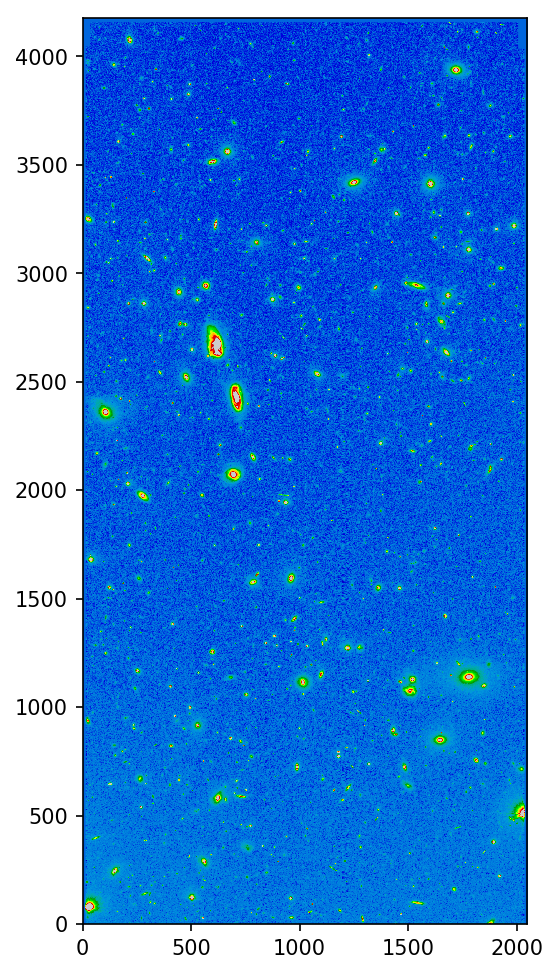

In [85]:
%matplotlib inline
imdat = amp1a
fig = plt.figure(figsize=(8, 8), dpi=150, facecolor='w', edgecolor='k')
plt.imshow(imprep(amp1a.image.array, scaletype='asinh', scalemode=99.7, 
                  colmap='nipy_spectral', smoothfwhm=3), 
           origin='lower')
plt.show()

In [92]:
np.quantile(imdat.image.array, 0.2), np.quantile(imdat.image.array, 0.8)

(281.7402038574219, 295.7839660644531)

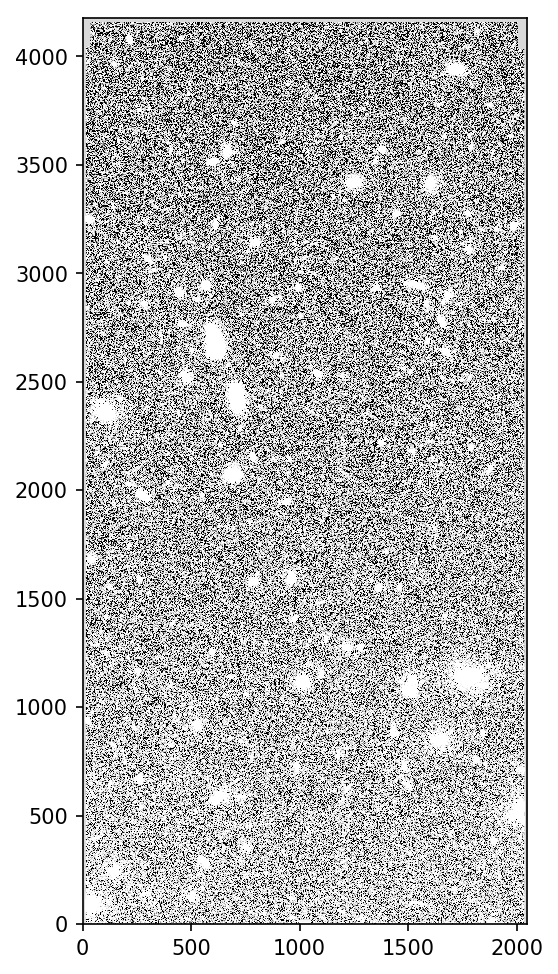

In [119]:
%matplotlib inline
imdat = amp1a
fig = plt.figure(figsize=(8, 8), dpi=150, facecolor='w', edgecolor='k')
plt.imshow(imprep(imdat.image.array, scaletype='asinh', zlo=281.74, zhi=295.78, 
                  colmap='Greys_r', smoothfwhm=0), 
           origin='lower')
plt.show()

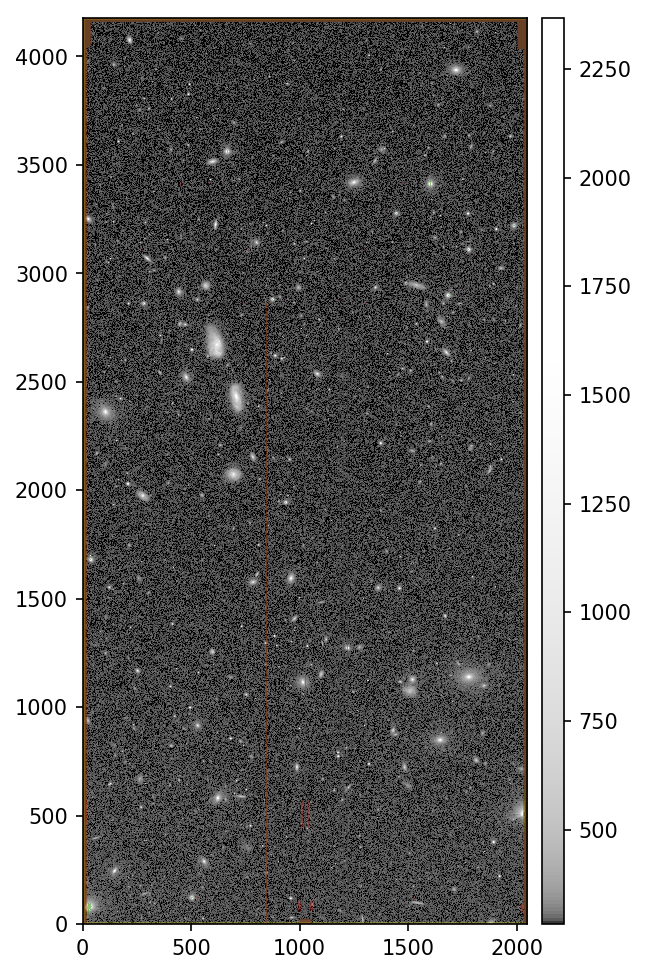

In [113]:
%matplotlib inline
imdat = amp1a
fig = plt.figure(figsize=(8, 8), dpi=150, facecolor='w', edgecolor='k')
display = afwDisplay.getDisplay(backend='matplotlib', frame=fig)
display.scale(algorithm="asinh", min=281.74, max=295.78)
display.mtv(imdat)
display.close()

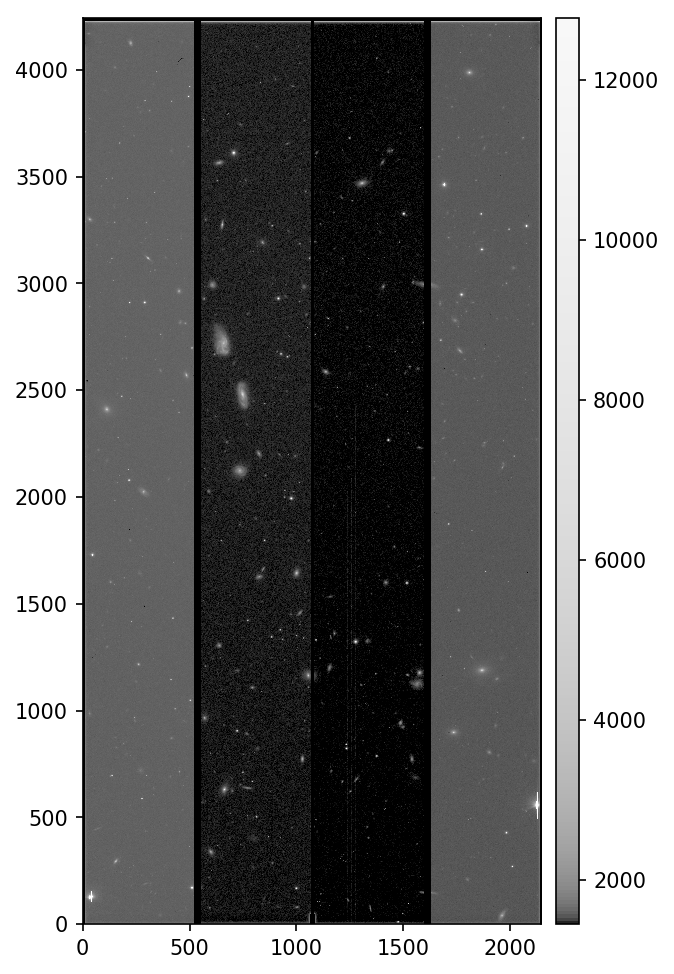

In [41]:
%matplotlib inline
imdat = amp1b
fig = plt.figure(figsize=(8, 8), dpi=150, facecolor='w', edgecolor='k')
display = afwDisplay.getDisplay(backend='matplotlib', frame=fig)
display.scale("asinh", np.quantile(imdat.image.array, 0.2), np.quantile(imdat.image.array, 0.8))
display.mtv(imdat)
display.close()

In [39]:
%matplotlib inline
imdat = amp1c
fig = plt.figure(figsize=(8, 8), dpi=150, facecolor='w', edgecolor='k')
display = afwDisplay.getDisplay(backend='matplotlib', frame=fig)
display.scale("asinh", np.quantile(imdat.image.array, 0.2), np.quantile(imdat.image.array, 0.8))
display.mtv(imdat)
display.close()

AttributeError: 'lsst.afw.cameraGeom.camera.camera.Camera' object has no attribute 'image'

<Figure size 1200x1200 with 0 Axes>

In [56]:
dir(amp1c[0].getAmplifiers()[0].getRawBBox())

['EXPAND',
 'EdgeHandlingEnum',
 'Extent',
 'Point',
 'SHRINK',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'area',
 'beginX',
 'beginY',
 'centerX',
 'centerY',
 'clip',
 'clippedTo',
 'contains',
 'dilatedBy',
 'endX',
 'endY',
 'erodedBy',
 'expandedTo',
 'flipLR',
 'flipTB',
 'getArea',
 'getBegin',
 'getBeginX',
 'getBeginY',
 'getCenter',
 'getCenterX',
 'getCenterY',
 'getCorners',
 'getDimensions',
 'getEnd',
 'getEndX',
 'getEndY',
 'getHeight',
 'getMax',
 'getMaxX',
 'getMaxY',
 'getMin',
 'getMinX',
 'getMinY',
 'getSlices',
 'getWidth',
 'getX',
 'getY',
 'grid',
 'grow',
 'height',
 'include',
 'intersects',
 'isDisjointFrom',
 'isEmpty',
 'makeCenteredBox',
 'ma

In [16]:
i=0
rerunfile = rerundir + '/c%03d.fits' % (camera[i].getId())
rerunfile

'/project/lskelvin/hsc-rerun/isrvanilla1252/postISRCCD/c000.fits'

In [120]:
rerunfile = basedir + '/c%03d.fits' % (camera[i].getId())
rerundata = fits.getdata(rerunfile)
test = rerundata[0:100,0:100]

In [7]:
rerundata.shape

NameError: name 'rerundata' is not defined

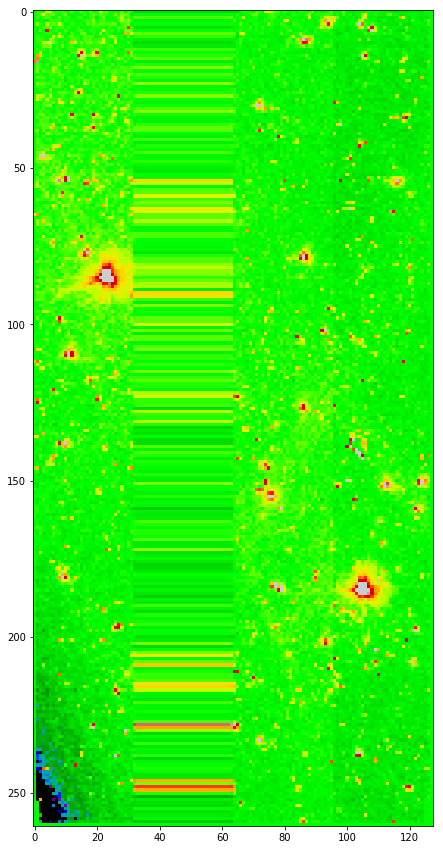

In [221]:
plt.figure(figsize=(15,15))
plt.imshow(aimage(rebin(rerundata,(4176/16, 2048/16)), scale=99.5), cmap='nipy_spectral')
plt.show()

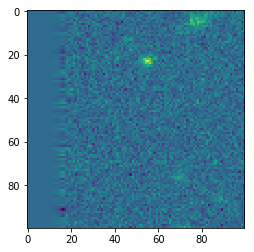

In [121]:
#%matplotlib inline
plt.imshow(np.log10(test))
plt.show()

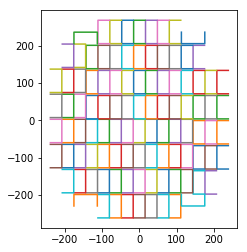

In [79]:
# generate focal plane plot
reruns = sorted(glob.glob(rerunfileglob, recursive=True))
basedir = os.path.dirname(reruns[0])

for i in range(len(camera)):
    
    # rerun CCD image
    rerunfile = basedir + '/c%03d.fits' % (camera[i].getId())
    rerundata = fits.getdata(rerunfile)
    
    if os.path.exists(rerunfile):
        
        # get CCD image
        hdu_list = fits.open(rerunfile)
        image_data = hdu_list[0].data
        hdu_list.close()
        
        pixToFocal = camera[i].getTransform(lsst.afw.cameraGeom.PIXELS, lsst.afw.cameraGeom.FOCAL_PLANE)
        corners = pixToFocal.applyForward(camera[i].getCorners(lsst.afw.cameraGeom.PIXELS))
        plt.plot(*zip(*corners))
        plt.gca().set_aspect('equal', adjustable='box')

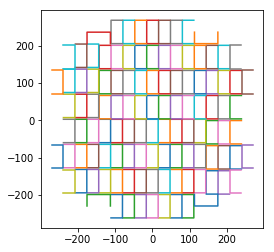

In [8]:
for i in range(len(camera)):
    pixToFocal = camera[i].getTransform(lsst.afw.cameraGeom.PIXELS, lsst.afw.cameraGeom.FOCAL_PLANE)
    corners = pixToFocal.applyForward(camera[i].getCorners(lsst.afw.cameraGeom.PIXELS))
    plt.plot(*zip(*corners))
    #centers = pixToFocal.applyForward(camera[i].getCenter(lsst.afw.cameraGeom.PIXELS))
    #plt.plot(centers[0], centers[1], 'bo')
    plt.gca().set_aspect('equal', adjustable='box')

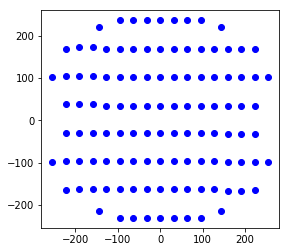

In [9]:
for i in range(len(camera)):
    pixToFocal = camera[i].getTransform(lsst.afw.cameraGeom.PIXELS, lsst.afw.cameraGeom.FOCAL_PLANE)
    #corners = pixToFocal.applyForward(camera[i].getCorners(lsst.afw.cameraGeom.PIXELS))
    #plt.plot(*zip(*corners), 'bo')
    centers = pixToFocal.applyForward(camera[i].getCenter(lsst.afw.cameraGeom.PIXELS))
    plt.plot(centers[0], centers[1], 'bo')
    plt.gca().set_aspect('equal', adjustable='box')

In [ ]:
# generate 

In [20]:
# define amps
camera = butler.get('camera')
det = camera[ccd]
amp1, amp2, amp3, amp4 = det.getAmplifiers()

KeyError: 'ccd'

In [6]:
# raw data bounding boxes
dbox1 = amp1.getRawDataBBox()
dbox2 = amp2.getRawDataBBox()
dbox3 = amp3.getRawDataBBox()
dbox4 = amp4.getRawDataBBox()

In [7]:
# horizontal overscan bounding boxes
obox1 = amp1.getRawHorizontalOverscanBBox()
obox2 = amp2.getRawHorizontalOverscanBBox()
obox3 = amp3.getRawHorizontalOverscanBBox()
obox4 = amp4.getRawHorizontalOverscanBBox()

In [8]:
# obsTable data
filtername = [d['filtername'] for d in np.asarray(obsTable)]
if band != 'all': 
    goodfilters = [i for i,s in enumerate(filtername) if band in s]
    filtername = np.asarray(filtername)[goodfilters]
else: 
    goodfilters = range(len(filtername))
filtername = np.array(filtername)
visits = obsTable['visit'][goodfilters]
exptime = obsTable['exptime'][goodfilters]
skybackground = obsTable['skybackground'][goodfilters]
mjd = obsTable['mjd'][goodfilters]
t = Time(mjd, format="mjd")
obsdate = t.decimalyear
ufname,ufcount = np.unique(filtername, return_counts=True)
print('\033[1m')
print('Number of visits:', visits.size)
print('Number of visits by filter:', dict(zip(ufname,ufcount)))
print('Number of pixel rows:', dbox1.getHeight())
print('Exposure time range:', '[', "%.0f" % np.min(exptime), ':', "%.0f" % np.max(exptime), ']')
print('Sky background range:', '[', "%.2f" % np.min(skybackground), ':', "%.2f" % np.max(skybackground), ']')
print('Date of Obs. range:', '[', "%.2f" % np.min(obsdate), ':', "%.2f" % np.max(obsdate), ']')
print('\033[0m')


Number of visits: 5190
Number of visits by filter: {'g': 1030, 'i': 1041, 'r': 925, 'y': 1032, 'z': 1162}
Number of pixel rows: 4176
Exposure time range: [ 30 : 270 ]
Sky background range: [ 56.01 : 14375.22 ]
Date of Obs. range: [ 2014.23 : 2015.87 ]



In [9]:
# image of CCD data regions for single visit

# setup
devscale = 2 # number of stdevs/madevs to plot either side
readme = open('%s/README.md' % outdir, 'w')
readme.write("# CCD %s Visit Plots\n" % ccd)

# visit list
ids = np.array(np.where(np.array(filtername) == 'g')).tolist()[0][0:20]
ids.extend(np.array(np.where(np.array(filtername) == 'r')).tolist()[0][0:20])
ids.extend(np.array(np.where(np.array(filtername) == 'i')).tolist()[0][0:20])
ids.extend(np.array(np.where(np.array(filtername) == 'z')).tolist()[0][0:20])
ids.extend(np.array(np.where(np.array(filtername) == 'y')).tolist()[0][0:20])

# loop
counter = 0
for imvisit, imfilter in zip(visits[ids], filtername[ids]):
    
    # counter
    counter += 1
    if (counter % 20) == 0:
        print('On %d of %d' % (counter, len(ids)))
    
    # setup
    doutname = '%s/ccd%03d_visit%s_%s_data.png' % (outdir, ccd, imvisit, imfilter)
    ooutname = '%s/ccd%03d_visit%s_%s_overscan.png' % (outdir, ccd, imvisit, imfilter)
    
    # write README file
    readme.write("### CCD %s: visit %s, filter %s" % (ccd, imvisit, imfilter))
    readme.write("![](%s)\n" % os.path.split(doutname)[1])
    readme.write("![](%s)\n" % os.path.split(ooutname)[1])
    
    # check files exist
    if ( (not os.path.exists(doutname)) or (not os.path.exists(ooutname)) ):
        
        # butler
        raw = butler.get('raw', visit=int(imvisit), ccd=ccd)
        
        # get map for each data region (converted to int64)
        data1 = raw.maskedImage[dbox1].getArrays()[0].astype(np.int64)
        data2 = raw.maskedImage[dbox2].getArrays()[0].astype(np.int64)
        data3 = raw.maskedImage[dbox3].getArrays()[0].astype(np.int64)
        data4 = raw.maskedImage[dbox4].getArrays()[0].astype(np.int64)
        
        # get map for each horizontal overscan region (converted to int64)
        overscan1 = raw.maskedImage[obox1].getArrays()[0].astype(np.int64)
        overscan2 = raw.maskedImage[obox2].getArrays()[0].astype(np.int64)
        overscan3 = raw.maskedImage[obox3].getArrays()[0].astype(np.int64)
        overscan4 = raw.maskedImage[obox4].getArrays()[0].astype(np.int64)
        
        # rebin, log, subtract mean/median, rescale to std/mad, and rotate
        ddownscale = 4
        mdata = []
        for data in [data1, data2, data3, data4]:
            temp = np.log10(rebin(data, new_shape=tuple(np.array(data.shape)/ddownscale)))
            temp -= np.median(temp)
            temp /= mad(temp)
            temp = np.rot90(temp)
            mdata.append(temp)
        
        # rebin, subtract mean/median, rescale to std/mad, and rotate
        odownscale = 24
        moverscan = []
        for overscan in [overscan1, overscan2, overscan3, overscan4]:
            temp = rebin(overscan, new_shape=(np.array(overscan.shape)[0]/odownscale, np.array(overscan.shape)[1]))
            temp -= np.median(temp)
            temp /= mad(temp)
            temp = np.rot90(temp)
            moverscan.append(temp)
        
        # data plot setup
        fig = plt.figure(constrained_layout=False, figsize=(13,6.5), dpi=300)
        spec = plt.GridSpec(ncols=25, nrows=4, figure=fig)
        ax1 = fig.add_subplot(spec[0, 0:-3])
        ax2 = fig.add_subplot(spec[1, 0:-3])
        ax3 = fig.add_subplot(spec[2, 0:-3])
        ax4 = fig.add_subplot(spec[3, 0:-3])
        ax0 = fig.add_subplot(spec[:, -1])
        axs = [ax4, ax3, ax2, ax1]

        # data plot plotting
        for i, mod, orig in zip([0,1,2,3], mdata, [data1,data2,data3,data4]):
            im = axs[i].imshow(mod, vmin=-devscale, vmax=devscale)
            axs[i].set_axis_off()
            axs[i].text(1.05, 0.5, "amp %s" % (i+1), 
                        horizontalalignment='center', verticalalignment='center', transform = axs[i].transAxes, 
                        fontsize=12, rotation=-90)
            axs[i].text(1.03, 0.5, "med = %.0f" % np.median(orig), 
                        horizontalalignment='center', verticalalignment='center', transform = axs[i].transAxes, 
                        fontsize=8, rotation=-90)
            axs[i].text(1.01, 0.5, "log(MAD) = %.4f" % mad(np.log10(orig)), 
                        horizontalalignment='center', verticalalignment='center', transform = axs[i].transAxes, 
                        fontsize=8, rotation=-90)

        # colorbar
        fig.colorbar(im, cax=ax0)
        ax0.text(3, 0.5, "log MAD offset from median", 
                 horizontalalignment='center', verticalalignment='center', transform = ax0.transAxes, 
                 fontsize=14, rotation=-90)

        # data plot finish up
        fig.text(0.5, 0.91, "CCD %s data: visit %s, filter %s" % (ccd, imvisit, imfilter), 
                 horizontalalignment='center', verticalalignment='center', transform = fig.transFigure, 
                 fontsize=16)
        fig.text(0.15, 0.09, "y pixel position / %s ⟶" % ddownscale, 
                 horizontalalignment='left', verticalalignment='center', transform = fig.transFigure, 
                 fontsize=14)
        fig.text(0.11, 0.16, "⟵ x pixel position / %s" % ddownscale, 
                 horizontalalignment='center', verticalalignment='bottom', transform = fig.transFigure, 
                 fontsize=14, rotation=-90)
        plt.savefig(doutname, dpi='figure')
        plt.close(fig)
        
        # overscan plot setup
        fig = plt.figure(constrained_layout=False, figsize=(13,11), dpi=300)
        spec = plt.GridSpec(ncols=25, nrows=8, figure=fig)
        ax1a = fig.add_subplot(spec[1, :-3])
        ax1d = fig.add_subplot(spec[0, :-3])
        ax1h = fig.add_subplot(spec[1, -3:-1])
        ax2a = fig.add_subplot(spec[3, :-3])
        ax2d = fig.add_subplot(spec[2, :-3])
        ax2h = fig.add_subplot(spec[3, -3:-1])
        ax3a = fig.add_subplot(spec[5, :-3])
        ax3d = fig.add_subplot(spec[4, :-3])
        ax3h = fig.add_subplot(spec[5, -3:-1])
        ax4a = fig.add_subplot(spec[7, :-3])
        ax4d = fig.add_subplot(spec[6, :-3])
        ax4h = fig.add_subplot(spec[7, -3:-1])
        ax0 = fig.add_subplot(spec[:, -1])
        axsa = [ax4a, ax3a, ax2a, ax1a]
        axsd = [ax4d, ax3d, ax2d, ax1d]
        axsh = [ax4h, ax3h, ax2h, ax1h]

        # overscan plot plotting
        for i, mod, orig, over0, over1 in zip([0,1,2,3], moverscan, [overscan1,overscan2,overscan3,overscan4], 
                                              [overscan1[:, 0],overscan2[:, -1],overscan3[:, 0],overscan4[:, -1]], 
                                              [overscan1[:, -1],overscan2[:, 0],overscan3[:, -1],overscan4[:, 0]]
                                             ):

            # 2D plot
            im = axsa[i].imshow(mod, vmin=-devscale, vmax=devscale)
            axsa[i].set_axis_off()
            axsa[i].text(0, 1.17, "amp %s" % (i+1), 
                         horizontalalignment='left', verticalalignment='center', transform = axsa[i].transAxes, 
                         fontsize=12, rotation=0)
            axsa[i].text(0.075, 1.17, "med = %.0f" % np.median(orig), 
                         horizontalalignment='left', verticalalignment='center', transform = axsa[i].transAxes, 
                         fontsize=12, rotation=0)
            axsa[i].text(0.205, 1.17, "MAD = %.3f" % mad(orig), 
                         horizontalalignment='left', verticalalignment='center', transform = axsa[i].transAxes, 
                         fontsize=12, rotation=0)

            # delta overscan line plot
            t0 = (over0 - np.median(orig)) / mad(orig)
            t1 = (over1 - np.median(orig)) / mad(orig)
            axsd[i].set_ylim([-3.5,3.5])
            #axsd[i].yaxis.set_major_locator(plt.MaxNLocator(3))
            axsd[i].set_yticks([-2,-1,0,1,2])
            #axsd[i].set_yticklabels([])
            axsd[i].yaxis.tick_right()
            axsd[i].yaxis.set_ticks_position('none')
            axsd[i].margins(x=0, y=0)
            axsd[i].axes.get_xaxis().set_visible(False)
            axsd[i].xaxis.set_ticks_position('none')
            axsd[i].set_xticklabels([])
            axsd[i].spines['top'].set_visible(False)
            axsd[i].spines['bottom'].set_visible(False)
            axsd[i].spines['left'].set_visible(False)
            axsd[i].spines['right'].set_visible(False)
            #axsd[i].plot(np.linspace(0, 1, num=len(over0)), over1-over0, color='#998ec3')
            axsd[i].plot(np.linspace(0, 1, num=len(over0)), run_mean(t0-t1, k=odownscale+1), 
                         linewidth=3, color='#f1a340')
            axsd[i].grid(color='grey', linestyle='dotted')
            axsd[i].axhline(y=0, color='black')
            axsd[i].tick_params(labelsize=8)
            axsd[i].text(1.04, 0.5, "Δₒ / MAD", 
                         horizontalalignment='center', verticalalignment='center', transform = axsd[i].transAxes, 
                         fontsize=10, rotation=-90)

            # collapsed 2D line plot
            #axsh[i].axvline(x=0, color='black')
            axsh[i].plot((np.mean(orig, axis=0) - np.median(orig)) / mad(orig), range(16), 
                         linewidth=5, color='#998ec3')
            axsh[i].set_ylim([-1,16])
            axsh[i].set_xlim([-2.5,2.5])
            axsh[i].margins(x=0, y=0)
            axsh[i].grid(color='grey', linestyle='dotted')
            axsh[i].spines['top'].set_visible(False)
            axsh[i].spines['bottom'].set_visible(False)
            axsh[i].spines['left'].set_visible(False)
            axsh[i].spines['right'].set_visible(False)
            #axsh[i].set_xticklabels([])
            #axsh[i].set_yticklabels([])
            #axsh[i].yaxis.set_ticks_position('none')
            #axsh[i].xaxis.set_major_locator(plt.MaxNLocator(3))
            axsh[i].set_xticks([-2,-1,0,1,2])
            #axsh[i].xaxis.tick_top()
            axsh[i].xaxis.set_ticks_position('none')
            axsh[i].axes.get_yaxis().set_visible(False)
            axsh[i].tick_params(labelsize=8)
            if i == 0:
                axsh[i].text(0.5, -0.35, "Σf / MAD", 
                             horizontalalignment='center', verticalalignment='center', transform = axsh[i].transAxes, 
                             fontsize=10, rotation=0)

        # colorbar
        fig.colorbar(im, cax=ax0)
        ax0.text(3, 0.5, "MAD offset from median", 
                 horizontalalignment='center', verticalalignment='center', transform = ax0.transAxes, 
                 fontsize=14, rotation=-90)

        # overscan plot finish up
        fig.text(0.5, 0.91, "CCD %s overscan: visit %s, filter %s" % (ccd, imvisit, imfilter), 
                 horizontalalignment='center', verticalalignment='center', transform = fig.transFigure, 
                 fontsize=16)
        fig.text(0.14, 0.1, "y pixel position / %s ⟶" % odownscale, 
                 horizontalalignment='left', verticalalignment='center', transform = fig.transFigure, 
                 fontsize=14)
        fig.text(0.105, 0.15, "⟵ x pixel position", 
                 horizontalalignment='center', verticalalignment='bottom', transform = fig.transFigure, 
                 fontsize=14, rotation=-90)
        plt.savefig(ooutname, dpi='figure')
        plt.close(fig)

# finish up
readme.close()

On 20 of 100
On 40 of 100
On 60 of 100
On 80 of 100
On 100 of 100


In [10]:
print("\033[1mall done!\033[0m")

all done!
